# 250131 New notebook just for analysis
Previous notebook, 2023_Training, has everything for starting from scratch with a model including labelling images and training the model. This notebook will just use the already trained model

Analysis that we want as output from the video recordings:
- Mouse position over time
- Percent time running per phase
- External work completed, which is the quantification of energy required to complete the task the mice completed, distinct from the internal work which would be the amount of energy the mouse actually expends. The latter likely to be greater, indicating some metabolic inefficiency.

## REQUIREMENTS TO RUN NOTEBOOK

Save a csv meta file in the "meta" folder with the follozing columns:
- time: time in min. Include a row for each min of experiment. Each row indicates what happened in the previous minute, so start at t = 1 and end at 60 min for a 60 min protocol.
- phase: Exercise phase, this will be dictate how the data is binned for analysis. Just number each distinct phase you want the data to be summmarized together. For example, first phase is sitting still, second phase is 6 m/min, or the first 5 min of a constant run protocol is phase 1, then the second five minutes is phase 2 ...
- speed: Treadmill speed in m/min
- incline: Treadmill inclination in degrees, negative values indicate downhill running

For analysis we need to know a few things:
- Scale at the level of the treadmill. Noting that the treadmill belt is 270 mm long, the entire enclosure is 365 mm long and 60 mm wide, and the walls are 5 mm thick. Export a frame of the video and open in ImageJ to check the scale. Default is 5 pixels per cm.
- Frames per second, and how many frames to extract. Default is 30 fps, and to extract one frame per second, i.e. every 30th frame. FPS is determined by the camera and application used to capture the video. The extraction interval may be chosen, increasing will slow the modeling process. 


In [2]:
# Directories. Define root yourself, it is likely the folder holding this notebook.
ROOT = "/Volumes/Backup_Plus/RSJ_Lab/Treadmill_VideoAnalysis_backupCode/YOLOV5_TreadmillVision/Mouse_Treadmill_Computer_Vision"

# Where the videos are saved
VIDEOS_PATH = "/Volumes/Backup_Plus/RSJ_Lab/Treadmill_Videos/250217"

# define experiment name
EXPERIMENT_NAME = "BJW0705_Downhill_1"

# meta file name with .csv
META_NAME = "250217_meta.csv"

incline = 10 # absolute value of treadmill incline or decline in degrees

# notebook has two steps. First the computer vision model is run to track mice in each frame step defined (default every 30 frames from 30 fps video) and output a csv of mouse position per frame
# step 2 is to analyze the position per frame csv files.
# Step 1 takes about 1 min per 5 min of video, so the below variable is asking whether or not to run the first step.
conduct_cv = 0

scale = 5 # pixels per cm
fps = 30 # video frames per second, depend on camera and application conducting the recording
interval = 30 # take every xth frame from the video. E.g., if this matches the fps then one frame per second will be analyzed


In [ ]:
# run to pip install required packages
# !pip install -r requirements.txt

In [ ]:
# pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


_____________________________________________________

In [3]:
import os
import torch
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
from sklearn.cluster import KMeans
import seaborn as sns


In [4]:
os.chdir(ROOT)
RESULTS_PATH = os.path.join('results')
if not os.path.exists(RESULTS_PATH):
    if os.name == 'posix':      # for mac, will change for windows
        !mkdir -p {RESULTS_PATH}

# where results will be stored, script will make the folder if not present yet
os.chdir(RESULTS_PATH)
EXPERIMENT_PATH = os.path.join(EXPERIMENT_NAME)
if not os.path.exists(EXPERIMENT_PATH):
    if os.name == 'posix':
        !mkdir -p {EXPERIMENT_PATH}

# where results will be stored, script will make the folder if not present yet
os.chdir(ROOT)
META_PATH = os.path.join("meta")
if not os.path.exists(META_PATH):
    if os.name == 'posix':
        !mkdir -p {META_PATH}

os.chdir(ROOT)

incline = abs(incline)

In [5]:
# enter the desired experiment from yolov5/runs/train
# this is telling yolov5 that we want to use a custom model, and then we tell it which weights to use
# this is the model from 2023 that identifies mice running from right to left with often greater than 80% confidence
model_trained = torch.hub.load('ultralytics/yolov5','custom',path='yolov5/runs/train/exp2/weights/best.pt')

Using cache found in /Users/brennanwadsworth/.cache/torch/hub/ultralytics_yolov5_master
WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

YOLOv5 🚀 2023-7-17 Python-3.10.12 torch-2.0.1 CPU

Fusing layers... 
Model summary: 157 layers, 7055974 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


## Below cell conducts the computer vision steps

- This will take about 1 min per 5 min of video
- Position data for all mice will be stored in a csv file in the results folder

In [ ]:
os.chdir(ROOT)
for roots, dirs, files in os.walk(VIDEOS_PATH):
    videos = files
print(f'{len(videos)} videos for analysis')

if conduct_cv:
    for video in videos:
        print(video)
        os.chdir(ROOT)
        vidObj = cv2.VideoCapture(os.path.join(VIDEOS_PATH,video)) # collects video object in cv2 framework
        df = pd.DataFrame(columns=['frame', 'xmin','ymin','xmax','ymax','confidence','class','name'])
        success = True
        count = 0
        while success:
            success, img = vidObj.read() # this will step by step read each frame of the video
            if success and count % interval == 0:
                results = model_trained(img)
                df = pd.concat([df,results.pandas().xyxy[0].join(pd.Series([count] * results.pandas().xyxy[0].shape[0], name="frame"))],ignore_index=True)
            count += 1
        df.to_csv(f'{RESULTS_PATH}/{EXPERIMENT_PATH}/{video}_tracking_results.csv')

12 videos for analysis


In [7]:
# code below for looking at a snapshot output of the video
if conduct_cv:
    %matplotlib inline
    plt.imshow(np.squeeze(results.render()))
    plt.show()

### Next function takes inputs about the experiment and conducts the analysis on the tracking results csv files

We will define a function that will require the following inputs:
- Frame rate of video (fps)
- Extracted frame interval (frames), e.g. 30 indicates every 30th frame collected, for 30 fps this is 1 fps extracted
- Scale in pixels per cm, for 20250131 position of camera, this is approximately 5.0 pixels per cm


In [13]:
def tracking_analysis(input_df, input_meta, fps = 30, interval = 30, scale = 5.0):
    # check that only tracking mice class, and of good confidence - the fan is identified as a mouse at low confidence
    df = input_df.loc[input_df["class"] == 15, :].loc[input_df.confidence >= 0.5, :]
    df["time"] = df.frame/(60*fps) # convert frame column to time in minutes

    # determine number of mice and threshold for relative position
    # cannot assume that the first measure from each frame is always the same mouse
    # treadmills are approximately 9 cm apart, so if the centroid of two clusters of y_min values are not
    #   at least 8 cm apart, then there is only one mouse. If they are separate, then a threshold of half the distance is appropriate
    kmeans = KMeans(n_clusters=2).fit(pd.DataFrame(df.loc[:,"ymin"]))
    if abs((kmeans.cluster_centers_[1] - kmeans.cluster_centers_[0])/scale) > 8:
        mouse_count = 2
        threshold = np.mean(kmeans.cluster_centers_)
        print("Two mice identified in this video at y values approx:", kmeans.cluster_centers_)
    else:
        mouse_count = 1
        print("Only one mouse identified in this video at y value approx: ", np.mean(df.ymin))
    
    df["mouse"] = pd.Series(df.ymin < threshold).astype(int)
    
    # determine mouse position over time.
    # Camera angle means data collection may not be equal between the two treadmills, e.g. angle or glare may obscure mouse in treadmill 1
    #   more than treadmill 2. The scale, i.e. pixels per mm, should be close enough to be assumed identical. So quantifying mouse velocity should be the same
    # What will be different due to camera angle is the x position indicating that the mouse is stationary on the electric grid. This will be done separately per treadmill
    # Some outlier data extist, so to reliably capture the xmin location of the front and back of the treadmill, take the 2nd and 95th percentile xmin values
    df_2 = pd.DataFrame()
    for mouse in range(mouse_count):
        mouse_df = df.loc[df.mouse == mouse, :].copy()
        fan_x = mouse_df.xmin.quantile(0.02)
        # drop rows with xmin beyond 27 cm (length of treadmill) of estimated fan location
        mouse_df.drop(mouse_df.loc[mouse_df.xmin > fan_x + scale * 27].index, inplace=True) # treadmill should be 27 cm

        grid_x = mouse_df.xmin.quantile(0.95)
        run_threshold = ((grid_x - fan_x) * 0.8) + fan_x
        print("endpoints of treadmill are estimated as xmin values of: \n treadmill", mouse, fan_x, grid_x)
        mouse_df["running"] = pd.Series(mouse_df.xmin < run_threshold).astype(int)

        # we need to know how many frames there is no mouse detected
        t_max = df["frame"].max() # number of frames in video
        t_frames = pd.DataFrame()
        t_frames["frames_t"] = pd.Series(np.arange(0, t_max, 30)) # number of frames analyzed based on indicated collection interval
        t_frames["time"] = t_frames.frames_t/(fps*60)
        # merge the mouse_df with the list of total frames expected, then fill in the na values assuming the mouse is at the grid
        df_na = mouse_df.merge(t_frames, how="outer", on="time")
        df_na.loc[df_na.frame.isna(), "frame"] = df_na.loc[df_na.frame.isna(), "frames_t"] # make new frame value in proper column
        df_na.xmin.fillna(grid_x + scale, inplace=True) # assign new x position at grid
        df_na.mouse.fillna(df_na.mouse[0], inplace=True) # make the mouse value match
        df_na.name.fillna(df_na.name[0], inplace=True) # fill in other identifiers
        df_na.confidence.fillna(0.8, inplace=True) # ensure values pass confidence filter
        df_na["class"].fillna(df_na["class"][0], inplace=True) # 
        df_na.fillna(0, inplace=True) # other values not necessary, just zero

        df_2 = pd.concat([df_2, df_na], ignore_index=True)
    
    # round-up time values to match meta file, then merge to get the treadmill speed at each time point, clean df to remove unneeded columns
    df_2["time_round"] = df_2.time.apply(np.ceil).astype(int)
    df_3 = pd.merge(left=df_2, right=input_meta, left_on="time_round", right_on="time", how="left").fillna(0).drop(["ymin", "xmax", "ymax", "confidence", "class", "name", "frames_t", "time_y", "time_round", "incline"], axis=1).rename(columns={"time_x":"time"})

    # Percent time running per phase
    stats_df = pd.DataFrame()
    for mouse in range(mouse_count):
        mouse_df = df_3.loc[df_3.mouse == mouse, :].copy()
        run_df = mouse_df.loc[mouse_df.speed > 0, :]
        stats_df[f"mouse_{mouse}_percent_time_running"] = pd.Series(run_df.groupby("phase").mean().running)*100
    
    # Next is external work calculation, which first requires velocity, which requires change in position over time
    df_4 = pd.DataFrame()
    for mouse in range(mouse_count):
        mouse_df = df_3.loc[df_3.mouse == mouse, :].copy().set_index("frame").sort_index() # get frames in order after adding in the missing frames
        mouse_df["velocity"] = mouse_df.xmin.diff(1)/(scale*interval/fps) # output now cm/s
        df_4 = pd.concat([df_4, mouse_df], ignore_index=False)

    # add treadmill speed to mouse speed only when: meta file states that treadmill is moving, mouse is running (not negative velocity and not on electrical grid)
    df_6 = df_4.reset_index()
    df_6.loc[df_6.velocity > 0, "running"] = 0 # positive velocity indicates that the mouse is moving towards increased x values, which in this case is towards the grid, i.e. the treadmill is moving the mouse

    df_5 = df_6.loc[df_6.running == 1, ["velocity", "speed"]].copy()
    df_5["speed_new"] = df_5.speed * 100/60     # convert m/min treadmill speed to cm/s by multiplying by 100 and dividing by 60
    df_5["velocity_new"] = df_5.velocity - df_5.speed_new

    df_6["velocity_new"] = pd.concat([df_6.loc[df_6.running == 0, "velocity"], df_5.loc[:,"velocity_new"]])

    constants = 9.8 * np.sin(np.pi*incline/180) # angle has to be converted from degrees to radians, divide angle by 180 and multiply by pi
    df_6["work_per_kg"] = df_6.velocity_new * constants/100 # divide by 100 to get from cm/s to m/s

    df_6.loc[df_6.velocity > 0, "work_per_kg"] = 0
    df_6.loc[df_6.speed == 0, "work_per_kg"] = 0

    return df_6, stats_df

In [14]:
os.chdir(ROOT)
for roots, dirs, files in os.walk(VIDEOS_PATH):
    videos = files
print(f'{len(videos)} videos for analysis')
print(videos)
os.chdir(ROOT)
meta_file = pd.read_csv(f"{META_PATH}/{META_NAME}")

for video in videos:
    print(video)
    try:
        df = pd.read_csv(f'{RESULTS_PATH}/{EXPERIMENT_PATH}/{video}_tracking_results.csv')
        output_df, stats_df = tracking_analysis(df, meta_file)
        output_df.to_csv(f"{RESULTS_PATH}/{EXPERIMENT_PATH}/{video}_analysis.csv")
        stats_df.to_csv(f"{RESULTS_PATH}/{EXPERIMENT_PATH}/{video}_percent time running.csv")
    except ValueError as e:
        print(f"Value Error for video: {video}", e)
    except FileNotFoundError as e:
        print(f"File Not Found for video: {video}", e)


12 videos for analysis
['WIN_20250217_13_11_45_D11D12.mp4', '._WIN_20250217_13_11_45_D11D12.mp4', 'WIN_20250217_15_20_43_D41D42mp4.mp4', '._WIN_20250217_15_20_43_D41D42mp4.mp4', 'WIN_20250217_16_06_11_D43D44.mp4', '._WIN_20250217_16_06_11_D43D44.mp4', 'WIN_20250217_17_10_54_D31D32.mp4', '._WIN_20250217_17_10_54_D31D32.mp4', 'WIN_20250217_17_50_22_D33D34.mp4', '._WIN_20250217_17_50_22_D33D34.mp4', '._WIN_20250217_14_02_46_D13D14_full.mp4', 'WIN_20250217_14_02_46_D13D14_full.mp4']
WIN_20250217_13_11_45_D11D12.mp4
Two mice identified in this video at y values approx: [[     111.79]
 [     39.496]]
endpoints of treadmill are estimated as xmin values of: 
 treadmill 0 34.606866455078126 152.6451187133789
endpoints of treadmill are estimated as xmin values of: 
 treadmill 1 51.042948150634764 168.296240234375
._WIN_20250217_13_11_45_D11D12.mp4
Value Error for video: ._WIN_20250217_13_11_45_D11D12.mp4 Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by KMeans.
WIN_

External work (P) according to multiple publications will be: P = mgvsinθ, where m is the unsupported mass in kg (in this case just mouse mass), g is the gravitational field strength 9.8 N/kg, v is velocity in m/min, and sin of the angle in degrees. This notebook will report work rate per kilogram, which can be converted after output based on individual mouse mass values.


power = mass (kg) * g (9.8N/kg) * v (m/s) * sin(10)
power = N*m/s = Watt

power / mass = g * v * sin(10) = W/kg

work = mass (kg) * g (N/kg) * sin(10) * v (m/s) * t (1s) = N*m = J

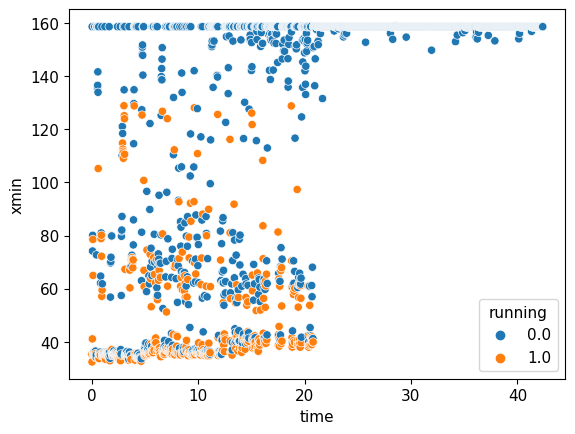

In [15]:
%matplotlib inline 

df_test = output_df.loc[output_df.mouse == 0, :]
sns.scatterplot(df_test, x="time", y="xmin", hue="running")
plt.show()

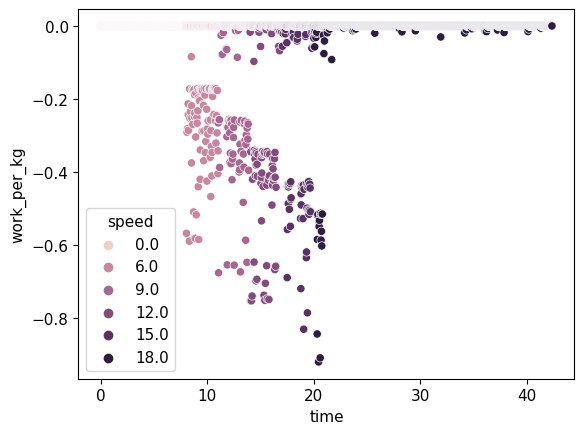

In [16]:
%matplotlib inline 

df_test = output_df.loc[output_df.mouse == 0, :]
sns.scatterplot(df_test, x="time", y="work_per_kg", hue="speed")
plt.show()